<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/CBAM_FINAL_NDM_1lyr_vtt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten, Add, multiply, Permute, Lambda, Concatenate
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras import backend as K
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [31]:
#from tensorflow.keras.optimizers import SGD

In [32]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/Dataset 090'
train_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 090/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 090/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 090/test'
attention_module = 'cbam_block'
#nico

In [33]:
classLabels =['covid','normal', 'pneumonia']

In [34]:
def attach_attention_module(net, attention_module):
  #if attention_module == 'se_block': # SE_block
    #net = se_block(net)
  if attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

In [35]:
def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


In [36]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In [37]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [38]:
input = Input(shape=(256,256,3))

In [39]:
#Layer 1
model = layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu')(input)
model = layers.BatchNormalization(name='norm_1')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides= 2)(model)
attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [40]:
#Layer 2
model = layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')(model)
model = layers.Dropout(0.1)(model)
model = layers.BatchNormalization(name='norm_2')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

#attention_module = 'cbam_block'
#y = attach_attention_module(model, attention_module)
#model =  tensorflow.keras.layers.add([model, y])


In [41]:
# Layer 3
model = layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu')(model)
model = layers.BatchNormalization(name='norm_3')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

#attention_module = 'cbam_block'
#y = attach_attention_module(model, attention_module)
#model =  tensorflow.keras.layers.add([model, y])



In [42]:
# Layer 4
model = layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_4')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

#attention_module = 'cbam_block'
#y = attach_attention_module(model, attention_module)
#model =  tensorflow.keras.layers.add([model, y])


In [43]:
# Layer 5
model = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')(model)
layer = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')
batch = layers.BatchNormalization(name='norm_5')
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_5')(model)
#model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

In [44]:
model = layers.Flatten()(model)
model = layers.Dense(128, activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
output = layers.Dense(3,Activation('softmax'))(model)
model = Model(input, output)

In [45]:
#output = model.output_shape

In [46]:
print(input)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [47]:
#initial_learning_rate=0.0001

In [48]:
#lr_schedule = ExponentialDecay(
#   initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
#)


In [49]:
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [50]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [51]:
print(model.summary())
print(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 256, 256, 32  128         ['conv_1[0][0]']                 
                                )                                                           

In [52]:
X = []
Y = []
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

In [53]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
#First cut all images from validation to train (if any exists)
transferAllClassBetweenFolders('valid', 'train', 1.0)
transferAllClassBetweenFolders('test', 'train', 1.0)
#no valid
transferAllClassBetweenFolders('train', 'test', 0.2)

In [54]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='micro')
    f1Score=f1_score(y_true, y_pred, average='micro') 
    recall = recall_score(y_true, y_pred, average='micro')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("Recall : {}".format(recall))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

    print("***----------------------------***")  
    return accuracy, precision, f1Score, recall

In [55]:
transferAllClassBetweenFolders('valid', 'train', 1.0)
#no valid
#transferAllClassBetweenFolders('test', 'train', 1.0)
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

skf = StratifiedKFold(n_splits=5
                      , shuffle=True)
skf.get_n_splits(X, Y)
print(skf)
print(skf.get_n_splits(X,Y))
print(skf.split(X,Y))
foldNum=0
overAllAcc = 0
overAllPrec = 0
overAllf1 = 0
overAllRec = 0

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
['COVID(409).png' 'COVID(406).png' 'COVID(405).png' ...
 'person825_bacteria_2736.jpeg' 'person820_virus_1456.jpeg'
 'person820_bacteria_2731.jpeg']
[0 0 0 ... 2 2 2]
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
5
<generator object _BaseKFold.split at 0x7f10ab662ad0>


trn_indx: 1728 test_indx: 432
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
1728
432
Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Epoch 1/25
54/54 - 745s - loss: 1.0570 - accuracy: 0.8692 - val_loss: 5.0725 - val_accuracy: 0.5301 - 745s/epoch - 14s/step
Epoch 2/25
54/54 - 22s - loss: 0.1847 - accuracy: 0.9427 - val_loss: 3.6959 - val_accuracy: 0.6898 - 22s/epoch - 414ms/step
Epoch 3/25
54/54 - 23s - loss: 0.1090 - accuracy: 0.9664 - val_loss: 0.1477 - val_accuracy: 0.9514 - 23s/epoch - 420ms/step
Epoch 4/25
54/54 - 23s - loss: 0.0850 - accuracy: 0.9711 - val_loss: 1.2990 - val_accuracy: 0.8171 - 23s/epoch - 421ms/step
Epoch 5/25
54/54 - 23s - loss: 0.2254 - accuracy: 0.9635 - val_loss: 22.0061 - val_accuracy: 0.5949 - 23s/epoch - 417ms/step
Epoch 6/25
54/54 - 23s - loss: 0.2780 - accuracy: 0.9427 - val_loss: 0.7778 - val_accuracy: 0.8287 - 23s/epoch

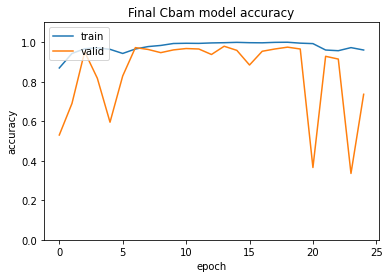

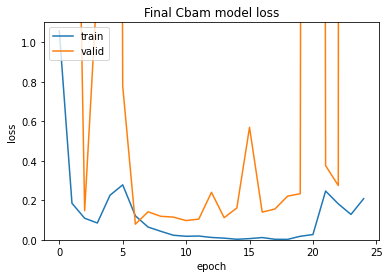

***Performance Data***
Accuracy  : 0.7296296296296296
Precision : 0.7296296296296296
f1Score : 0.7296296296296296
Recall : 0.7296296296296296
[[175   5   0]
 [ 10 169   1]
 [ 66  64  50]]
***----------------------------***
17/17 [==============================] - 6s 335ms/step - loss: 8.8059 - accuracy: 0.7296
***-----------------------------------------------***
Overall Accuracy:  0.7296296296296296
Overall Precision:  0.7296296296296296
Overall f1Score:  0.7296296296296296
Overall Recall:  0.7296296296296296
***------------------End of Line------------------***
trn_indx: 1728 test_indx: 432
Results for fold 2
1728
432
Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Epoch 1/25
54/54 - 23s - loss: 0.0870 - accuracy: 0.9722 - val_loss: 0.0513 - val_accuracy: 0.9838 - 23s/epoch - 424ms/step
Epoch 2/25
54/54 - 23s - loss: 0.0608 - accuracy: 0.9797 - val_loss: 0.5131 - val_accuracy: 0.7755 - 23s/epoch - 420ms/step


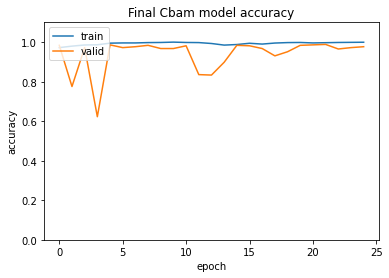

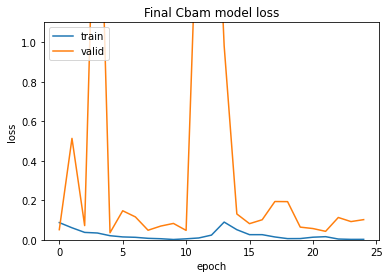

***Performance Data***
Accuracy  : 0.9629629629629629
Precision : 0.9629629629629629
f1Score : 0.9629629629629629
Recall : 0.9629629629629629
[[179   1   0]
 [  1 172   7]
 [  8   3 169]]
***----------------------------***
17/17 [==============================] - 5s 335ms/step - loss: 0.1904 - accuracy: 0.9630
***-----------------------------------------------***
Overall Accuracy:  0.8462962962962963
Overall Precision:  0.8462962962962963
Overall f1Score:  0.8462962962962963
Overall Recall:  0.8462962962962963
***------------------End of Line------------------***
trn_indx: 1728 test_indx: 432
Results for fold 3
1728
432
Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Epoch 1/25
54/54 - 23s - loss: 0.0650 - accuracy: 0.9867 - val_loss: 0.2225 - val_accuracy: 0.9282 - 23s/epoch - 427ms/step
Epoch 2/25
54/54 - 23s - loss: 0.0639 - accuracy: 0.9867 - val_loss: 0.9818 - val_accuracy: 0.7639 - 23s/epoch - 421ms/step


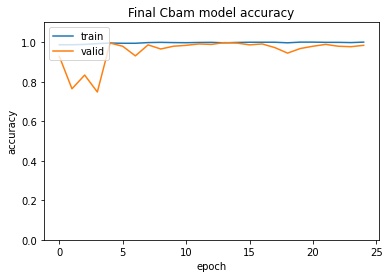

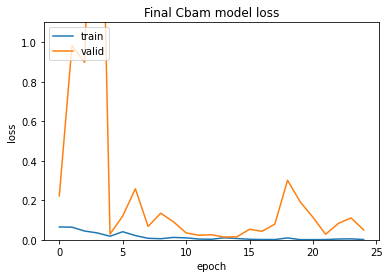

***Performance Data***
Accuracy  : 0.9666666666666667
Precision : 0.9666666666666667
f1Score : 0.9666666666666667
Recall : 0.9666666666666667
[[180   0   0]
 [  0 178   2]
 [  3  13 164]]
***----------------------------***
17/17 [==============================] - 5s 335ms/step - loss: 0.2546 - accuracy: 0.9667
***-----------------------------------------------***
Overall Accuracy:  0.8864197530864198
Overall Precision:  0.8864197530864198
Overall f1Score:  0.8864197530864198
Overall Recall:  0.8864197530864198
***------------------End of Line------------------***
trn_indx: 1728 test_indx: 432
Results for fold 4
1728
432
Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Epoch 1/25
54/54 - 23s - loss: 0.0443 - accuracy: 0.9902 - val_loss: 0.1557 - val_accuracy: 0.9583 - 23s/epoch - 424ms/step
Epoch 2/25
54/54 - 23s - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.0826 - val_accuracy: 0.9815 - 23s/epoch - 422ms/step


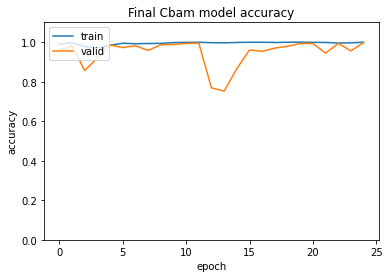

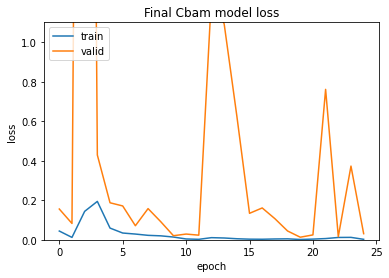

***Performance Data***
Accuracy  : 0.9722222222222222
Precision : 0.9722222222222222
f1Score : 0.9722222222222222
Recall : 0.9722222222222222
[[176   1   3]
 [  0 176   4]
 [  2   5 173]]
***----------------------------***
17/17 [==============================] - 5s 332ms/step - loss: 0.1758 - accuracy: 0.9722
***-----------------------------------------------***
Overall Accuracy:  0.9078703703703704
Overall Precision:  0.9078703703703704
Overall f1Score:  0.9078703703703704
Overall Recall:  0.9078703703703704
***------------------End of Line------------------***
trn_indx: 1728 test_indx: 432
Results for fold 5
1728
432
Found 1728 images belonging to 3 classes.
Found 432 images belonging to 3 classes.
Found 540 images belonging to 3 classes.
Epoch 1/25
54/54 - 23s - loss: 0.0196 - accuracy: 0.9971 - val_loss: 0.0131 - val_accuracy: 0.9977 - 23s/epoch - 425ms/step
Epoch 2/25
54/54 - 23s - loss: 0.0195 - accuracy: 0.9959 - val_loss: 0.0188 - val_accuracy: 0.9954 - 23s/epoch - 420ms/step


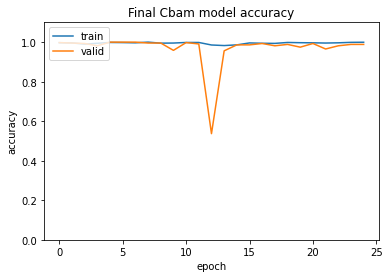

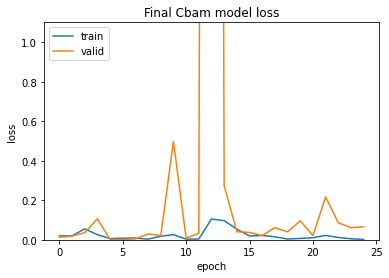

***Performance Data***
Accuracy  : 0.975925925925926
Precision : 0.975925925925926
f1Score : 0.975925925925926
Recall : 0.975925925925926
[[180   0   0]
 [  1 177   2]
 [  5   5 170]]
***----------------------------***
17/17 [==============================] - 5s 334ms/step - loss: 0.2790 - accuracy: 0.9759
***-----------------------------------------------***
Overall Accuracy:  0.9214814814814816
Overall Precision:  0.9214814814814816
Overall f1Score:  0.9214814814814816
Overall Recall:  0.9214814814814816
***------------------End of Line------------------***


In [56]:
for train_index, val_index in skf.split(X, Y):
    print("trn_indx: %s test_indx: %s" % (len(train_index), len(val_index)))
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('valid', 'train', 1.0)
    #no valid
    #transferAllClassBetweenFolders('test', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    print(len(X_train))
    print(len(X_val))
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    sourcePath+'/valid/'+classLabel+'/'+X_val[eachIndex])
        #without valid
                    #sourcePath+'/test/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=True)
    #without valid
    valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=True)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=False)

    history = model.fit(train_batches, 
                    #steps_per_epoch=sp_epoch, 
                    #without valid
                    validation_data=valid_batches, 
                    #validation_steps=10, 
                    epochs=25, 
                    verbose=2)
    
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Final Cbam model accuracy')
    plt.ylim(0,1.1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    #without valid
    #plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Final Cbam model loss')
    plt.ylim(0,1.1)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    #without valid
    #plt.legend(['train'], loc='upper left')
    plt.show()
    test_batches.reset()
    Y_pred = model.predict(test_batches)
    classes = test_batches.classes[test_batches.index_array]
    y_pred = np.argmax(Y_pred, axis=-1)
    #print("***Performance on Test Data***")  
    #print(sum(y_pred==classes)/10000)
    confusion_matrix(test_batches.classes[test_batches.index_array],y_pred)
    #predictions = model.predict(test_batches, verbose=1)
    #yPredictions = np.argmax(predictions, axis=1)
    #print(yPredictions)
    #true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance Data***")    
    #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
    valAcc, valPrec, valFScore, valRec = my_metrics(classes, y_pred)
    overAllAcc = overAllAcc+valAcc
    overAllPrec = overAllPrec+valPrec
    overAllf1 = overAllf1+valFScore
    overAllRec = overAllRec+valRec
    
    model.evaluate(test_batches)
    print("***-----------------------------------------------***")  
    print("Overall Accuracy: ",  overAllAcc/foldNum)
    print("Overall Precision: ",  overAllPrec/foldNum)
    print("Overall f1Score: ",  overAllf1/foldNum)
    print("Overall Recall: ",  overAllRec/foldNum)

    print("***------------------End of Line------------------***")    